Final_Images folder created with prepare_data.ipynb should be present

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/"Colab Notebooks"/Final_Images.zip /content/
!unzip Final_Images.zip -d /content/

Mounted at /content/drive
Archive:  Final_Images.zip
   creating: /content/Final_Images/
   creating: /content/Final_Images/A/
 extracting: /content/Final_Images/A/20586908_6c613a14b80a8591.png  
  inflating: /content/Final_Images/A/20586934_6c613a14b80a8591.png  
  inflating: /content/Final_Images/A/20586960_6c613a14b80a8591.png  
 extracting: /content/Final_Images/A/20586986_6c613a14b80a8591.png  
 extracting: /content/Final_Images/A/20587612_f4b2d377f43ba0bd.png  
  inflating: /content/Final_Images/A/20587664_f4b2d377f43ba0bd.png  
 extracting: /content/Final_Images/A/20587758_81cd83d2f4d78528.png  
 extracting: /content/Final_Images/A/20587810_81cd83d2f4d78528.png  
  inflating: /content/Final_Images/A/20587902_8dbbd4e51f549ff0.png  
  inflating: /content/Final_Images/A/20587928_8dbbd4e51f549ff0.png  
 extracting: /content/Final_Images/A/20587994_024ee3569b2605dc.png  
 extracting: /content/Final_Images/A/20588046_024ee3569b2605dc.png  
 extracting: /content/Final_Images/A/20588190

Download neccesary libraries

In [ ]:
!pip install openmim
!mim install 'mmcv >= 2.0.0rc1'

# Install mmseg
!git clone -b main https://github.com/open-mmlab/mmsegmentation.git
!cd mmsegmentation && pip install -e .

# Install mmdet
!git clone https://github.com/open-mmlab/mmdetection.git
!cd mmdetection && pip install -e .

Looking in links: https://download.openmmlab.com/mmcv/dist/cu121/torch2.1.0/index.html
fatal: destination path 'mmsegmentation' already exists and is not an empty directory.
Obtaining file:///content/mmsegmentation
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mmsegmentation
fatal: destination path 'mmdetection' already exists and is not an empty directory.
Obtaining file:///content/mmdetection
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mmdet


In [ ]:
!pip install ftfy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 2.0 MB/s eta 0:00:00


In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
%cd /content/mmdetection
import mmdet
print(mmdet.__version__)

# Check MMSegmentation installation
# active directory after this cell will be mmsegmentation
%cd /content/mmsegmentation
import mmseg
print(mmseg.__version__)

2.1.0+cu121 True
/content/mmdetection
3.3.0
/content/mmsegmentation
1.2.2


Import libraries

In [ ]:
import os
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset
import mmengine
import os.path as osp
import shutil
from mmengine import Config
from mmengine.runner import Runner
from mmseg.apis import init_model, inference_model, show_result_pyplot
import mmcv
import matplotlib.pyplot as plt

Count number of images

In [ ]:
def count_files_in_folder(folder_path):
    # Use os.listdir to get the list of files in the folder
    files = os.listdir(folder_path)

    # Use len to get the count of files
    file_count = len(files)

    return file_count

In [ ]:
folder_names = ['A', 'B', 'C', 'D', 'E']

for fn in folder_names:
  folder_path_images = '/content/Final_Images/' + fn
  folder_path_labels = '/content/Final_Images/' + fn + '_labels'

  # Call the function to count the files in the folder
  num_files_images = count_files_in_folder(folder_path_images)
  num_files_labels = count_files_in_folder(folder_path_labels)

  # Print the result
  print(f'The number of files in {folder_path_images} is: {num_files_images}')
  print(f'The number of files in {folder_path_labels} is: {num_files_labels}')

The number of files in /content/Final_Images/A is: 21
The number of files in /content/Final_Images/A_labels is: 21
The number of files in /content/Final_Images/B is: 22
The number of files in /content/Final_Images/B_labels is: 22
The number of files in /content/Final_Images/C is: 23
The number of files in /content/Final_Images/C_labels is: 23
The number of files in /content/Final_Images/D is: 21
The number of files in /content/Final_Images/D_labels is: 21
The number of files in /content/Final_Images/E is: 18
The number of files in /content/Final_Images/E_labels is: 18


Download model configuration

In [ ]:
# Download config and checkpoint files
!mim download mmsegmentation --config mask2former_r50_8xb2-160k_ade20k-512x512 --dest .

processing mask2former_r50_8xb2-160k_ade20k-512x512...
downloading ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.5/257.5 MiB 46.2 MB/s eta 0:00:00
Successfully downloaded mask2former_r50_8xb2-160k_ade20k-512x512_20221204_000055-2d1f55f1.pth to /content/mmsegmentation
Successfully dumped mask2former_r50_8xb2-160k_ade20k-512x512.py to /content/mmsegmentation


In [ ]:
palette = ([0,0,0],[255,0,0])
classes = ['None', 'Mass']

Create dataset loader

In [ ]:
@DATASETS.register_module()
class INBreast(BaseSegDataset):
  METAINFO = dict(classes=classes, palette=palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', **kwargs)

In [ ]:
def copy_contents(source_dir, destination_dir):
    # Get the list of files and directories in the source directory
    contents = os.listdir(source_dir)

    # Iterate over each item in the source directory
    for item in contents:
        # Form the absolute paths of the source item and destination item
        source_item_path = os.path.join(source_dir, item)
        destination_item_path = os.path.join(destination_dir, item)

        # Move the item to the destination directory
        shutil.copy(source_item_path, destination_item_path)

    names = []
    for c in contents:
      names.append(c.split('.')[0])
    return names

Create config for training

In [ ]:
def get_config(work_dir):
  data_root = '/content/mmsegmentation/INBreast'
  img_dir = 'images'
  ann_dir = 'labels'
  cfg = Config.fromfile('configs/mask2former/mask2former_r50_8xb2-160k_ade20k-512x512.py')

  # Load the pretrained weights
  cfg.load_from = 'mask2former_r50_8xb2-160k_ade20k-512x512_20221204_000055-2d1f55f1.pth'

  # Set up working dir to save files and logs
  cfg.work_dir = work_dir

  cfg.crop_size = (512, 512)  # Change this: desired crop size
  cfg.model.data_preprocessor.size = cfg.crop_size

  # Change this: set number of classes
  cfg.model.decode_head.num_classes = 2
  cfg.num_classes = 2

  cfg.dataset_type = 'INBreast'  # Name of the dataset you want to use
  cfg.data_root = data_root # Directory in which you have images/ and labels/ folders

  cfg.train_pipeline = [
      dict(type='LoadImageFromFile'),
      dict(type='LoadAnnotations'),
      dict(type='PackSegInputs')
  ]

  cfg.test_pipeline = [
      dict(type='LoadImageFromFile'),
      dict(type='LoadAnnotations'),
      dict(type='PackSegInputs')
  ]

  cfg.train_dataloader.dataset.type = cfg.dataset_type
  cfg.train_dataloader.dataset.data_root = cfg.data_root
  cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
  cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'  # file names for train set
  cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline


  cfg.val_dataloader.dataset.type = cfg.dataset_type
  cfg.val_dataloader.dataset.data_root = cfg.data_root
  cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
  cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'  # file names for val set
  cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline

  cfg.test_dataloader.dataset.type = cfg.dataset_type
  cfg.test_dataloader.dataset.data_root = cfg.data_root
  cfg.test_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
  cfg.test_dataloader.dataset.ann_file = 'splits/test.txt'  # file names for test set
  cfg.test_dataloader.dataset.pipeline = cfg.test_pipeline

  cfg.train_cfg.max_iters = 1000
  cfg.train_cfg.val_interval = 10
  cfg.default_hooks.logger.interval = 1
  cfg.default_hooks.checkpoint.interval = 500

  cfg['randomness'] = dict(seed=0)

  weights = [0.1, 1.0]
  weights.append(0.1) # Expected if you look at original config, need 0.1 as last item
  cfg.model.decode_head.loss_cls["class_weight"] = weights

  print(f'Config:\n{cfg.pretty_text}')
  return cfg

Function for testing trained model on one image

In [ ]:
def test_one_image(folder_name, cfg, work_dir):
  # Init the model from the config and the checkpoint
  checkpoint_path =  work_dir + '/iter_1000.pth'
  model = init_model(cfg, checkpoint_path, 'cuda:0')

  img_name = os.listdir('/content/Final_Images/' + folder_name)[0]

  # Load the original image
  img = mmcv.imread('/content/Final_Images/' + folder_name + '/' + img_name)

  # Perform inference to get segmentation result
  result = inference_model(model, img)

  # Create a subplot with 1 row and 3 columns
  plt.figure(figsize=(18, 6))

  # Plot the original image in the first subplot
  plt.subplot(1, 3, 1)
  plt.imshow(mmcv.bgr2rgb(img))
  plt.title('Original Image')

  # Plot the segmentation result in the second subplot
  plt.subplot(1, 3, 2)
  vis_result = show_result_pyplot(model, img, result)
  plt.imshow(mmcv.bgr2rgb(vis_result))
  plt.title('Segmentation Result')

  mask_img_name = os.listdir('/content/Final_Images/' + folder_name + '_labels')[0]

  # Load the resized image (assuming it's in the same directory as the original image)
  original_img_mask = '/content/Final_Images/' + folder_name + '_labels/' + mask_img_name
  mask_img = mmcv.imread(original_img_mask)

  # Plot the resized image in the third subplot
  plt.subplot(1, 3, 3)
  plt.imshow(mmcv.bgr2rgb(mask_img))
  plt.title('Original Mask')

  # Show the subplots
  plt.show()

Implementation of training

In [ ]:
def train(cross_valid_type, work_dir):
  if os.path.exists('/content/mmsegmentation/INBreast'):
    shutil.rmtree('/content/mmsegmentation/INBreast')

  os.makedirs('/content/mmsegmentation/INBreast', exist_ok=True)
  os.makedirs('/content/mmsegmentation/INBreast/images', exist_ok=True)
  os.makedirs('/content/mmsegmentation/INBreast/labels', exist_ok=True)

  source_folder = '/content/Final_Images/'

  train_names = []
  valid_names = []
  test_names = []

  for fn in cross_valid_type["train"]:
    copy_contents(source_folder + fn, '/content/mmsegmentation/INBreast/images')
    contents = copy_contents(source_folder + fn + '_labels', '/content/mmsegmentation/INBreast/labels')
    train_names += contents

  for fn in cross_valid_type["valid"]:
    copy_contents(source_folder + fn, '/content/mmsegmentation/INBreast/images')
    contents = copy_contents(source_folder + fn + '_labels', '/content/mmsegmentation/INBreast/labels')
    valid_names += contents

  for fn in cross_valid_type["test"]:
    copy_contents(source_folder + fn, '/content/mmsegmentation/INBreast/images')
    contents = copy_contents(source_folder + fn + '_labels', '/content/mmsegmentation/INBreast/labels')
    test_names += contents

  data_root = '/content/mmsegmentation/INBreast'
  split_dir = 'splits'
  mmengine.mkdir_or_exist(osp.join(data_root, split_dir))
  with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
    f.writelines(line + '\n' for line in train_names)
  with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
    f.writelines(line + '\n' for line in valid_names)
  with open(osp.join(data_root, split_dir, 'test.txt'), 'w') as f:
    f.writelines(line + '\n' for line in test_names)

  cfg = get_config(work_dir)

  runner = Runner.from_cfg(cfg)
  runner.train()

  runner.test()

  test_one_image(cross_valid_type['test'][0], cfg, work_dir)

Run training for each cross validation iteration

In [ ]:
cross_valid_types = [{"test" : ["A"], "valid" : ["B"], "train" : ["C", "D", "E"]},
                     {"test" : ["B"], "valid" : ["C"], "train" : ["D", "E", "A"]},
                     {"test" : ["C"], "valid" : ["D"], "train" : ["E", "A", "B"]},
                     {"test" : ["D"], "valid" : ["E"], "train" : ["A", "B", "C"]},
                     {"test" : ["E"], "valid" : ["A"], "train" : ["B", "C", "D"]}]

Config:
auto_scale_lr = dict(base_batch_size=16, enable=False)
crop_size = (
    512,
    512,
)
custom_imports = dict(allow_failed_imports=False, imports='mmdet.models')
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        512,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    test_cfg=dict(size_divisor=32),
    type='SegDataPreProcessor')
data_root = '/content/mmsegmentation/INBreast'
dataset_type = 'INBreast'
default_hooks = dict(
    checkpoint=dict(
        by_epoch=False, interval=500, save_best='mIoU', type='CheckpointHook'),
    logger=dict(interval=1, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
embed_multi =

/usr/local/lib/python3.10/dist-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmseg.visualization.local_visualizer.SegLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


02/26 21:03:16 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
02/26 21:03:16 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/content/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:60: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


02/26 21:03:17 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:lr=1e-05
02/26 21:03:17 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:weight_decay=0.05
02/26 21:03:17 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:lr_mult=0.1
02/26 21:03:17 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:decay_mult=1.0
02/26 21:03:17 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:lr=1e-05
02/26 21:03:17 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:weight_decay=0.05
02/26 21:03:17 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:lr_mult=0.1
02/26 21:03:17 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:decay_mult=1.0
02/26 21:03:17 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv2.weight:lr=1e-05
02/26 21:03:17 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv2.weight:weight_decay=0.05
02/26 21:03:17 - mmengine - INF

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


02/26 21:03:28 - mmengine - INFO - Iter(val) [ 1/22]    eta: 0:00:07  time: 0.3356  data_time: 0.2164  memory: 1001  
02/26 21:03:28 - mmengine - INFO - Iter(val) [ 2/22]    eta: 0:00:04  time: 0.2043  data_time: 0.1142  memory: 1001  
02/26 21:03:28 - mmengine - INFO - Iter(val) [ 3/22]    eta: 0:00:03  time: 0.1584  data_time: 0.0772  memory: 1001  
02/26 21:03:28 - mmengine - INFO - Iter(val) [ 4/22]    eta: 0:00:02  time: 0.1384  data_time: 0.0600  memory: 1001  
02/26 21:03:29 - mmengine - INFO - Iter(val) [ 5/22]    eta: 0:00:02  time: 0.1245  data_time: 0.0494  memory: 1001  
02/26 21:03:29 - mmengine - INFO - Iter(val) [ 6/22]    eta: 0:00:01  time: 0.1149  data_time: 0.0416  memory: 1014  
02/26 21:03:29 - mmengine - INFO - Iter(val) [ 7/22]    eta: 0:00:01  time: 0.1082  data_time: 0.0363  memory: 1001  
02/26 21:03:29 - mmengine - INFO - Iter(val) [ 8/22]    eta: 0:00:01  time: 0.1030  data_time: 0.0324  memory: 1001  
02/26 21:03:29 - mmengine - INFO - Iter(val) [ 9/22]    

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


02/26 21:16:01 - mmengine - INFO - Iter(test) [ 1/21]    eta: 0:00:10  time: 0.5147  data_time: 0.3556  memory: 1001  
02/26 21:16:01 - mmengine - INFO - Iter(test) [ 2/21]    eta: 0:00:05  time: 0.3101  data_time: 0.1930  memory: 1001  
02/26 21:16:01 - mmengine - INFO - Iter(test) [ 3/21]    eta: 0:00:04  time: 0.2347  data_time: 0.1337  memory: 1001  
02/26 21:16:01 - mmengine - INFO - Iter(test) [ 4/21]    eta: 0:00:03  time: 0.1974  data_time: 0.1035  memory: 1001  
02/26 21:16:01 - mmengine - INFO - Iter(test) [ 5/21]    eta: 0:00:02  time: 0.1768  data_time: 0.0857  memory: 1001  
02/26 21:16:01 - mmengine - INFO - Iter(test) [ 6/21]    eta: 0:00:02  time: 0.1623  data_time: 0.0728  memory: 1001  
02/26 21:16:01 - mmengine - INFO - Iter(test) [ 7/21]    eta: 0:00:02  time: 0.1539  data_time: 0.0665  memory: 1001  
02/26 21:16:01 - mmengine - INFO - Iter(test) [ 8/21]    eta: 0:00:01  time: 0.1468  data_time: 0.0589  memory: 1001  
02/26 21:16:02 - mmengine - INFO - Iter(test) [ 

/usr/local/lib/python3.10/dist-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


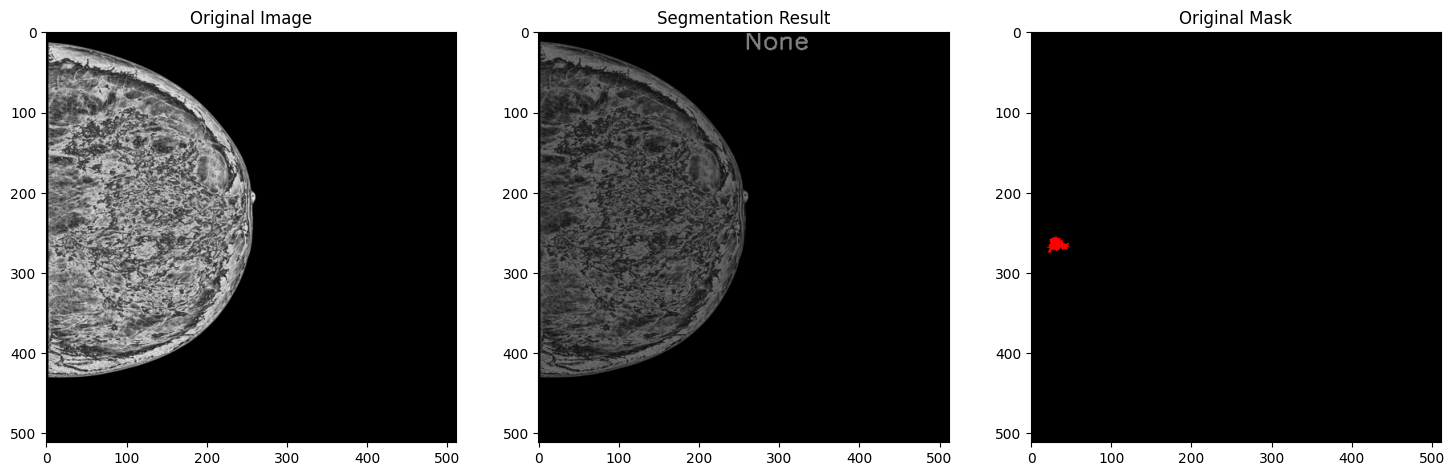

In [ ]:
train(cross_valid_types[0], './work_dirs/cross_valid_0')

Config:
auto_scale_lr = dict(base_batch_size=16, enable=False)
crop_size = (
    512,
    512,
)
custom_imports = dict(allow_failed_imports=False, imports='mmdet.models')
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        512,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    test_cfg=dict(size_divisor=32),
    type='SegDataPreProcessor')
data_root = '/content/mmsegmentation/INBreast'
dataset_type = 'INBreast'
default_hooks = dict(
    checkpoint=dict(
        by_epoch=False, interval=500, save_best='mIoU', type='CheckpointHook'),
    logger=dict(interval=1, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
embed_multi =

/usr/local/lib/python3.10/dist-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmseg.visualization.local_visualizer.SegLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


02/26 21:17:07 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
02/26 21:17:07 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/content/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:60: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


02/26 21:17:08 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:lr=1e-05
02/26 21:17:08 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:weight_decay=0.05
02/26 21:17:08 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:lr_mult=0.1
02/26 21:17:08 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:decay_mult=1.0
02/26 21:17:08 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:lr=1e-05
02/26 21:17:08 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:weight_decay=0.05
02/26 21:17:08 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:lr_mult=0.1
02/26 21:17:08 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:decay_mult=1.0
02/26 21:17:08 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv2.weight:lr=1e-05
02/26 21:17:08 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv2.weight:weight_decay=0.05
02/26 21:17:08 - mmengine - INF

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


02/26 21:17:17 - mmengine - INFO - Iter(val) [ 1/23]    eta: 0:00:08  time: 0.3677  data_time: 0.2694  memory: 1001  
02/26 21:17:17 - mmengine - INFO - Iter(val) [ 2/23]    eta: 0:00:04  time: 0.2202  data_time: 0.1377  memory: 1001  
02/26 21:17:17 - mmengine - INFO - Iter(val) [ 3/23]    eta: 0:00:03  time: 0.1714  data_time: 0.0944  memory: 1001  
02/26 21:17:17 - mmengine - INFO - Iter(val) [ 4/23]    eta: 0:00:02  time: 0.1466  data_time: 0.0731  memory: 1001  
02/26 21:17:17 - mmengine - INFO - Iter(val) [ 5/23]    eta: 0:00:02  time: 0.1311  data_time: 0.0591  memory: 1001  
02/26 21:17:17 - mmengine - INFO - Iter(val) [ 6/23]    eta: 0:00:02  time: 0.1212  data_time: 0.0506  memory: 1001  
02/26 21:17:17 - mmengine - INFO - Iter(val) [ 7/23]    eta: 0:00:01  time: 0.1145  data_time: 0.0443  memory: 1001  
02/26 21:17:17 - mmengine - INFO - Iter(val) [ 8/23]    eta: 0:00:01  time: 0.1090  data_time: 0.0391  memory: 1001  
02/26 21:17:17 - mmengine - INFO - Iter(val) [ 9/23]    

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


02/26 21:30:07 - mmengine - INFO - Iter(test) [ 1/22]    eta: 0:00:08  time: 0.4135  data_time: 0.3279  memory: 1001  
02/26 21:30:07 - mmengine - INFO - Iter(test) [ 2/22]    eta: 0:00:04  time: 0.2457  data_time: 0.1710  memory: 1001  
02/26 21:30:07 - mmengine - INFO - Iter(test) [ 3/22]    eta: 0:00:03  time: 0.1929  data_time: 0.1186  memory: 1001  
02/26 21:30:07 - mmengine - INFO - Iter(test) [ 4/22]    eta: 0:00:02  time: 0.1638  data_time: 0.0915  memory: 1001  
02/26 21:30:07 - mmengine - INFO - Iter(test) [ 5/22]    eta: 0:00:02  time: 0.1470  data_time: 0.0763  memory: 1001  
02/26 21:30:07 - mmengine - INFO - Iter(test) [ 6/22]    eta: 0:00:02  time: 0.1347  data_time: 0.0642  memory: 1001  
02/26 21:30:07 - mmengine - INFO - Iter(test) [ 7/22]    eta: 0:00:01  time: 0.1259  data_time: 0.0557  memory: 1001  
02/26 21:30:07 - mmengine - INFO - Iter(test) [ 8/22]    eta: 0:00:01  time: 0.1189  data_time: 0.0491  memory: 1001  
02/26 21:30:07 - mmengine - INFO - Iter(test) [ 

/usr/local/lib/python3.10/dist-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


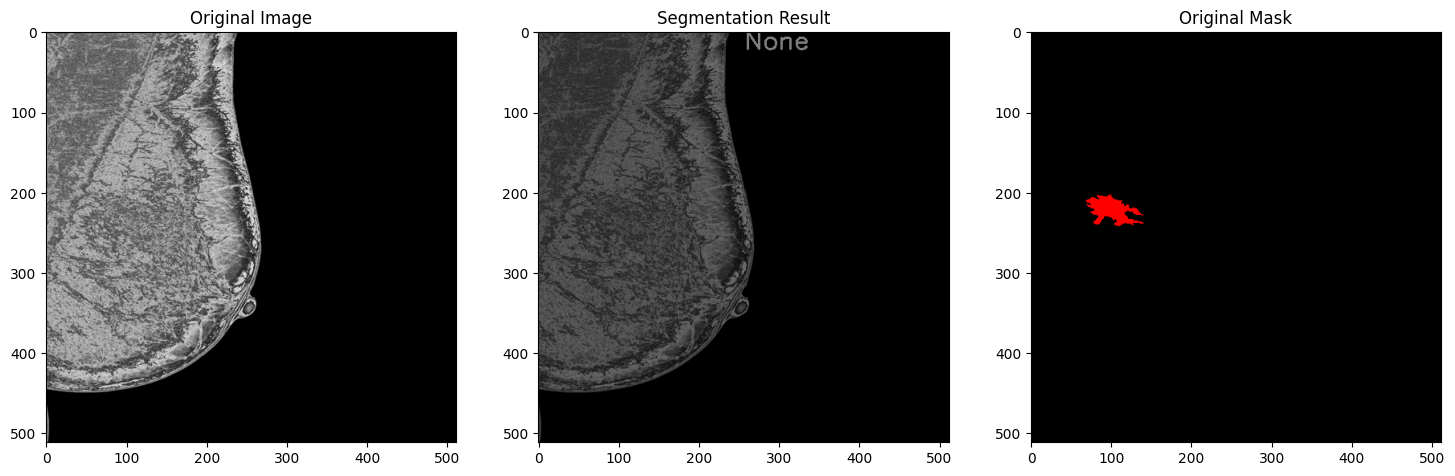

In [ ]:
train(cross_valid_types[1], './work_dirs/cross_valid_1')

Config:
auto_scale_lr = dict(base_batch_size=16, enable=False)
crop_size = (
    512,
    512,
)
custom_imports = dict(allow_failed_imports=False, imports='mmdet.models')
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        512,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    test_cfg=dict(size_divisor=32),
    type='SegDataPreProcessor')
data_root = '/content/mmsegmentation/INBreast'
dataset_type = 'INBreast'
default_hooks = dict(
    checkpoint=dict(
        by_epoch=False, interval=500, save_best='mIoU', type='CheckpointHook'),
    logger=dict(interval=1, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
embed_multi =

/usr/local/lib/python3.10/dist-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmseg.visualization.local_visualizer.SegLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


02/26 21:31:12 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
02/26 21:31:12 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/content/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:60: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


02/26 21:31:13 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:lr=1e-05
02/26 21:31:13 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:weight_decay=0.05
02/26 21:31:13 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:lr_mult=0.1
02/26 21:31:13 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:decay_mult=1.0
02/26 21:31:13 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:lr=1e-05
02/26 21:31:13 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:weight_decay=0.05
02/26 21:31:13 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:lr_mult=0.1
02/26 21:31:13 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:decay_mult=1.0
02/26 21:31:13 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv2.weight:lr=1e-05
02/26 21:31:13 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv2.weight:weight_decay=0.05
02/26 21:31:13 - mmengine - INF

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


02/26 21:31:23 - mmengine - INFO - Iter(val) [ 1/21]    eta: 0:00:07  time: 0.3744  data_time: 0.2698  memory: 1001  
02/26 21:31:23 - mmengine - INFO - Iter(val) [ 2/21]    eta: 0:00:04  time: 0.2244  data_time: 0.1404  memory: 1001  
02/26 21:31:23 - mmengine - INFO - Iter(val) [ 3/21]    eta: 0:00:03  time: 0.1759  data_time: 0.0979  memory: 1001  
02/26 21:31:23 - mmengine - INFO - Iter(val) [ 4/21]    eta: 0:00:02  time: 0.1492  data_time: 0.0744  memory: 1001  
02/26 21:31:23 - mmengine - INFO - Iter(val) [ 5/21]    eta: 0:00:02  time: 0.1331  data_time: 0.0601  memory: 1001  
02/26 21:31:23 - mmengine - INFO - Iter(val) [ 6/21]    eta: 0:00:01  time: 0.1236  data_time: 0.0508  memory: 1001  
02/26 21:31:23 - mmengine - INFO - Iter(val) [ 7/21]    eta: 0:00:01  time: 0.1162  data_time: 0.0446  memory: 1001  
02/26 21:31:23 - mmengine - INFO - Iter(val) [ 8/21]    eta: 0:00:01  time: 0.1100  data_time: 0.0395  memory: 1001  
02/26 21:31:24 - mmengine - INFO - Iter(val) [ 9/21]    

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


02/26 21:43:38 - mmengine - INFO - Iter(test) [ 1/23]    eta: 0:00:07  time: 0.3514  data_time: 0.2278  memory: 1001  
02/26 21:43:38 - mmengine - INFO - Iter(test) [ 2/23]    eta: 0:00:04  time: 0.2178  data_time: 0.1229  memory: 1001  
02/26 21:43:38 - mmengine - INFO - Iter(test) [ 3/23]    eta: 0:00:03  time: 0.1712  data_time: 0.0867  memory: 1001  
02/26 21:43:39 - mmengine - INFO - Iter(test) [ 4/23]    eta: 0:00:02  time: 0.1487  data_time: 0.0698  memory: 1001  
02/26 21:43:39 - mmengine - INFO - Iter(test) [ 5/23]    eta: 0:00:02  time: 0.1334  data_time: 0.0565  memory: 1001  
02/26 21:43:39 - mmengine - INFO - Iter(test) [ 6/23]    eta: 0:00:02  time: 0.1238  data_time: 0.0478  memory: 1001  
02/26 21:43:39 - mmengine - INFO - Iter(test) [ 7/23]    eta: 0:00:01  time: 0.1169  data_time: 0.0426  memory: 1001  
02/26 21:43:39 - mmengine - INFO - Iter(test) [ 8/23]    eta: 0:00:01  time: 0.1125  data_time: 0.0393  memory: 1001  
02/26 21:43:39 - mmengine - INFO - Iter(test) [ 

/usr/local/lib/python3.10/dist-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


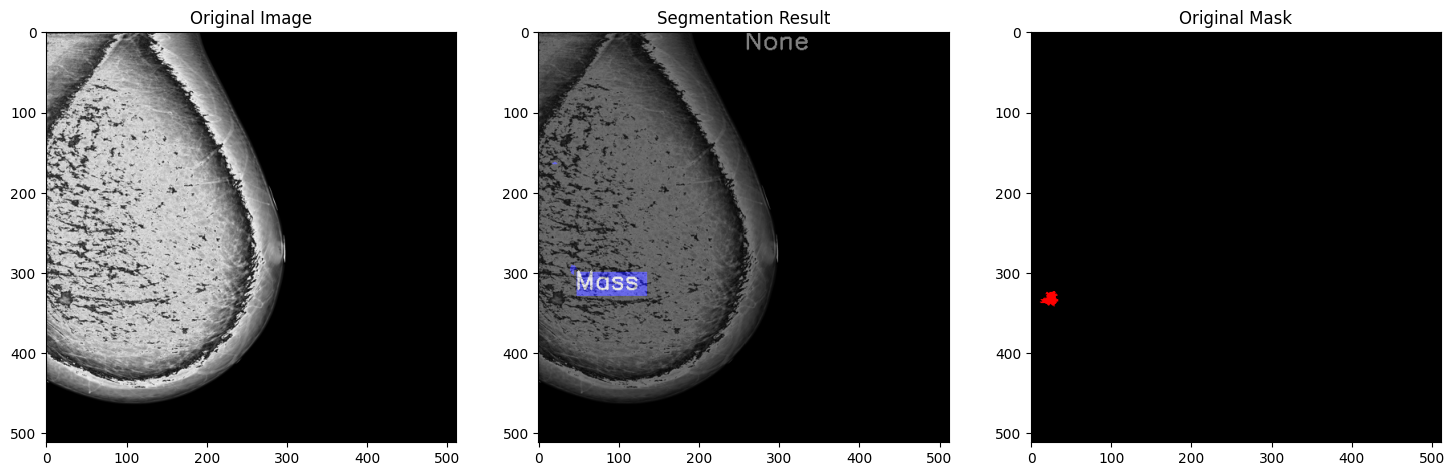

In [ ]:
train(cross_valid_types[2], './work_dirs/cross_valid_2')

Config:
auto_scale_lr = dict(base_batch_size=16, enable=False)
crop_size = (
    512,
    512,
)
custom_imports = dict(allow_failed_imports=False, imports='mmdet.models')
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        512,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    test_cfg=dict(size_divisor=32),
    type='SegDataPreProcessor')
data_root = '/content/mmsegmentation/INBreast'
dataset_type = 'INBreast'
default_hooks = dict(
    checkpoint=dict(
        by_epoch=False, interval=500, save_best='mIoU', type='CheckpointHook'),
    logger=dict(interval=1, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
embed_multi =

/usr/local/lib/python3.10/dist-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmseg.visualization.local_visualizer.SegLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


02/26 21:44:45 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
02/26 21:44:45 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/content/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:60: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


02/26 21:44:46 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:lr=1e-05
02/26 21:44:46 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:weight_decay=0.05
02/26 21:44:46 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:lr_mult=0.1
02/26 21:44:46 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:decay_mult=1.0
02/26 21:44:46 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:lr=1e-05
02/26 21:44:46 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:weight_decay=0.05
02/26 21:44:46 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:lr_mult=0.1
02/26 21:44:46 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:decay_mult=1.0
02/26 21:44:46 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv2.weight:lr=1e-05
02/26 21:44:46 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv2.weight:weight_decay=0.05
02/26 21:44:46 - mmengine - INF

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


02/26 21:44:55 - mmengine - INFO - Iter(val) [ 1/18]    eta: 0:00:08  time: 0.5067  data_time: 0.3679  memory: 1001  
02/26 21:44:55 - mmengine - INFO - Iter(val) [ 2/18]    eta: 0:00:04  time: 0.3036  data_time: 0.1948  memory: 1001  
02/26 21:44:55 - mmengine - INFO - Iter(val) [ 3/18]    eta: 0:00:03  time: 0.2327  data_time: 0.1367  memory: 1001  
02/26 21:44:55 - mmengine - INFO - Iter(val) [ 4/18]    eta: 0:00:02  time: 0.1962  data_time: 0.1059  memory: 1001  
02/26 21:44:55 - mmengine - INFO - Iter(val) [ 5/18]    eta: 0:00:02  time: 0.1750  data_time: 0.0874  memory: 1001  
02/26 21:44:55 - mmengine - INFO - Iter(val) [ 6/18]    eta: 0:00:01  time: 0.1606  data_time: 0.0751  memory: 1001  
02/26 21:44:55 - mmengine - INFO - Iter(val) [ 7/18]    eta: 0:00:01  time: 0.1504  data_time: 0.0671  memory: 1001  
02/26 21:44:55 - mmengine - INFO - Iter(val) [ 8/18]    eta: 0:00:01  time: 0.1441  data_time: 0.0607  memory: 1001  
02/26 21:44:55 - mmengine - INFO - Iter(val) [ 9/18]    

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


02/26 21:57:26 - mmengine - INFO - Iter(test) [ 1/21]    eta: 0:00:06  time: 0.3475  data_time: 0.2311  memory: 1001  
02/26 21:57:26 - mmengine - INFO - Iter(test) [ 2/21]    eta: 0:00:04  time: 0.2156  data_time: 0.1210  memory: 1001  
02/26 21:57:26 - mmengine - INFO - Iter(test) [ 3/21]    eta: 0:00:03  time: 0.1689  data_time: 0.0830  memory: 1001  
02/26 21:57:26 - mmengine - INFO - Iter(test) [ 4/21]    eta: 0:00:02  time: 0.1459  data_time: 0.0640  memory: 1001  
02/26 21:57:26 - mmengine - INFO - Iter(test) [ 5/21]    eta: 0:00:02  time: 0.1313  data_time: 0.0517  memory: 1001  
02/26 21:57:26 - mmengine - INFO - Iter(test) [ 6/21]    eta: 0:00:01  time: 0.1214  data_time: 0.0437  memory: 1001  
02/26 21:57:26 - mmengine - INFO - Iter(test) [ 7/21]    eta: 0:00:01  time: 0.1146  data_time: 0.0379  memory: 1001  
02/26 21:57:26 - mmengine - INFO - Iter(test) [ 8/21]    eta: 0:00:01  time: 0.1101  data_time: 0.0347  memory: 1001  
02/26 21:57:26 - mmengine - INFO - Iter(test) [ 

/usr/local/lib/python3.10/dist-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


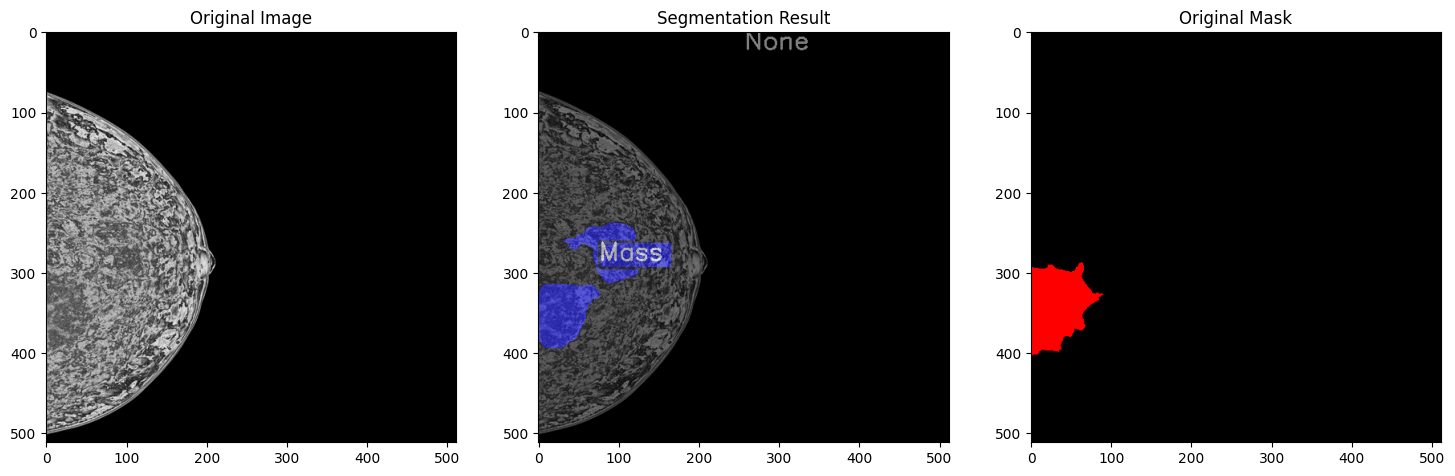

In [ ]:
train(cross_valid_types[3], './work_dirs/cross_valid_3')

Config:
auto_scale_lr = dict(base_batch_size=16, enable=False)
crop_size = (
    512,
    512,
)
custom_imports = dict(allow_failed_imports=False, imports='mmdet.models')
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        512,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    test_cfg=dict(size_divisor=32),
    type='SegDataPreProcessor')
data_root = '/content/mmsegmentation/INBreast'
dataset_type = 'INBreast'
default_hooks = dict(
    checkpoint=dict(
        by_epoch=False, interval=500, save_best='mIoU', type='CheckpointHook'),
    logger=dict(interval=1, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
embed_multi =

/usr/local/lib/python3.10/dist-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmseg.visualization.local_visualizer.SegLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


02/26 21:58:32 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
02/26 21:58:32 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/content/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:60: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


02/26 21:58:33 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:lr=1e-05
02/26 21:58:33 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:weight_decay=0.05
02/26 21:58:33 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:lr_mult=0.1
02/26 21:58:33 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:decay_mult=1.0
02/26 21:58:33 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:lr=1e-05
02/26 21:58:33 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:weight_decay=0.05
02/26 21:58:33 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:lr_mult=0.1
02/26 21:58:33 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv1.weight:decay_mult=1.0
02/26 21:58:33 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv2.weight:lr=1e-05
02/26 21:58:33 - mmengine - INFO - paramwise_options -- backbone.layer1.0.conv2.weight:weight_decay=0.05
02/26 21:58:33 - mmengine - INF

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


02/26 21:58:42 - mmengine - INFO - Iter(val) [ 1/21]    eta: 0:00:06  time: 0.3494  data_time: 0.2510  memory: 1001  
02/26 21:58:42 - mmengine - INFO - Iter(val) [ 2/21]    eta: 0:00:04  time: 0.2116  data_time: 0.1312  memory: 1001  
02/26 21:58:42 - mmengine - INFO - Iter(val) [ 3/21]    eta: 0:00:02  time: 0.1660  data_time: 0.0905  memory: 1001  
02/26 21:58:42 - mmengine - INFO - Iter(val) [ 4/21]    eta: 0:00:02  time: 0.1440  data_time: 0.0702  memory: 1000  
02/26 21:58:42 - mmengine - INFO - Iter(val) [ 5/21]    eta: 0:00:02  time: 0.1288  data_time: 0.0568  memory: 1001  
02/26 21:58:42 - mmengine - INFO - Iter(val) [ 6/21]    eta: 0:00:01  time: 0.1189  data_time: 0.0480  memory: 1001  
02/26 21:58:42 - mmengine - INFO - Iter(val) [ 7/21]    eta: 0:00:01  time: 0.1118  data_time: 0.0417  memory: 1001  
02/26 21:58:42 - mmengine - INFO - Iter(val) [ 8/21]    eta: 0:00:01  time: 0.1071  data_time: 0.0376  memory: 1001  
02/26 21:58:42 - mmengine - INFO - Iter(val) [ 9/21]    

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


02/26 22:11:48 - mmengine - INFO - Iter(test) [ 1/18]    eta: 0:00:06  time: 0.3851  data_time: 0.2893  memory: 1001  
02/26 22:11:48 - mmengine - INFO - Iter(test) [ 2/18]    eta: 0:00:03  time: 0.2324  data_time: 0.1494  memory: 1001  
02/26 22:11:48 - mmengine - INFO - Iter(test) [ 3/18]    eta: 0:00:02  time: 0.1824  data_time: 0.1033  memory: 1001  
02/26 22:11:48 - mmengine - INFO - Iter(test) [ 4/18]    eta: 0:00:02  time: 0.1589  data_time: 0.0815  memory: 1001  
02/26 22:11:48 - mmengine - INFO - Iter(test) [ 5/18]    eta: 0:00:01  time: 0.1409  data_time: 0.0663  memory: 1001  
02/26 22:11:49 - mmengine - INFO - Iter(test) [ 6/18]    eta: 0:00:01  time: 0.1298  data_time: 0.0557  memory: 1001  
02/26 22:11:49 - mmengine - INFO - Iter(test) [ 7/18]    eta: 0:00:01  time: 0.1223  data_time: 0.0482  memory: 1001  
02/26 22:11:49 - mmengine - INFO - Iter(test) [ 8/18]    eta: 0:00:01  time: 0.1169  data_time: 0.0442  memory: 1001  
02/26 22:11:49 - mmengine - INFO - Iter(test) [ 

/usr/local/lib/python3.10/dist-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


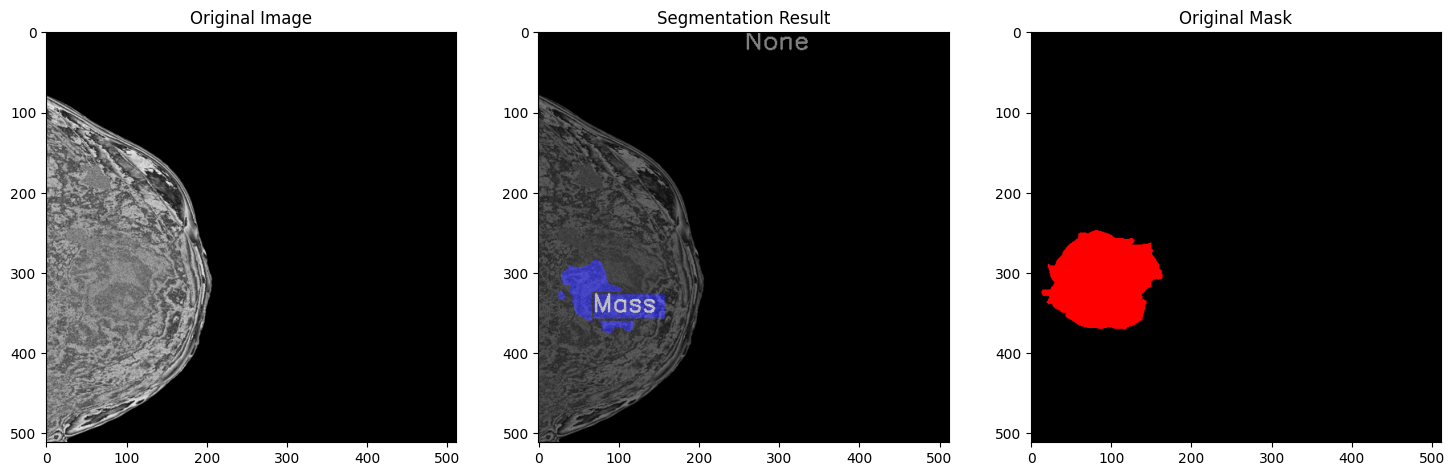

In [ ]:
train(cross_valid_types[4], './work_dirs/cross_valid_4')

Calculate and print final metrics

In [ ]:
#                    IoU,   Acc               IoU,   Acc
cross_0 = {"None" : [98.89, 99.98], "Mass" : [0.38, 0.38]}
cross_1 = {"None" : [98.87, 99.95], "Mass" : [27.31, 28.27]}
cross_2 = {"None" : [99.00, 99.42], "Mass" : [27.42, 47.54]}
cross_3 = {"None" : [98.84, 99.28], "Mass" : [28.81, 51.20]}
cross_4 = {"None" : [99.19, 99.99], "Mass" : [13.35, 13.53]}

In [ ]:
none_iou = round((cross_0["None"][0] + cross_1["None"][0] + cross_2["None"][0] + cross_3["None"][0] + cross_4["None"][0]) / 5, 2)
mass_iou = round((cross_0["Mass"][0] + cross_1["Mass"][0] + cross_2["Mass"][0] + cross_3["Mass"][0] + cross_4["Mass"][0]) / 5, 2)

none_acc = round((cross_0["None"][1] + cross_1["None"][1] + cross_2["None"][1] + cross_3["None"][1] + cross_4["None"][1]) / 5, 2)
mass_acc = round((cross_0["Mass"][1] + cross_1["Mass"][1] + cross_2["Mass"][1] + cross_3["Mass"][1] + cross_4["Mass"][1]) / 5, 2)

In [ ]:
print("Final metrics:")
print("+-------+-------+-------+")
print("| Class |  IoU  |  Acc  |")
print("+-------+-------+-------+")
print(f"|  None | {none_iou} | {none_acc} |")
print(f"|  Mass | {mass_iou} | {mass_acc} |")
print("+-------+-------+-------+")

Final metrics:
+-------+-------+-------+
| Class |  IoU  |  Acc  |
+-------+-------+-------+
|  None | 98.96 | 99.72 |
|  Mass | 19.45 | 28.18 |
+-------+-------+-------+
